In [16]:
# notebook dependencies 
import os # used in caching
import pandas as pd
import numpy as np

# visualization imports
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# regular expression import
import re

# JSON import
import json

# importing BeautifulSoup for parsing HTML/XTML
from bs4 import BeautifulSoup as BSoup

# request module for connecting to APIs
from requests import get

# text prepare modules
import acquire
import prepare

# uni-code library
import unicodedata

# natural language toolkit library/modules
import nltk
from nltk.stem import PorterStemmer, LancasterStemmer, WordNetLemmatizer

from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords

#sklearn
from sklearn.model_selection import train_test_split

# Wrangling

### Data Acquisition

In [2]:
# Reading in data
df = pd.read_csv('metaverse.csv')

In [3]:
df

,repo,language,readme_contents
0,M3-org/awesome-metaverse,NaN,# Awesome Metaverse [![Awesome](https://awesom...
1,mvs-org/metaverse,C++,Metaverse Core Integration/staging Tree\n=====...
2,webaverse/app,JavaScript,"<img src=""docs/banner.jpeg"" width=100% />\n\n<..."
3,shadowcz007/awesome-metaverse,NaN,"# awesome-metaverse\n<a href=""https://awesome...."
4,vircadia/vircadia,C++,"<p align=""center""><a href=""https://vircadia.co..."
...,...,...,...
993,LinasKo/MetaVerse,C#,# MetaVerse\nVirtual Conference project for Me...
994,saiva11/Metaverse,Vue,NaN
995,dimplehh/metaverse,NaN,# 맥스트 VPS SDK 사용\n\n## VPS 사용\n\nAssets\MaxstA...
996,niksanvijan/MetaVerse,NaN,NaN


In [4]:
# Looking at messy reame_contents
df.readme_contents

0      # Awesome Metaverse [![Awesome](https://awesom...
1      Metaverse Core Integration/staging Tree\n=====...
2      <img src="docs/banner.jpeg" width=100% />\n\n<...
3      # awesome-metaverse\n<a href="https://awesome....
4      <p align="center"><a href="https://vircadia.co...
                             ...                        
993    # MetaVerse\nVirtual Conference project for Me...
994                                                  NaN
995    # 맥스트 VPS SDK 사용\n\n## VPS 사용\n\nAssets\MaxstA...
996                                                  NaN
997                                                  NaN
Name: readme_contents, Length: 998, dtype: object

In [5]:
df.isnull().sum()

repo                 0
language           316
readme_contents    257
dtype: int64

### Data Preparation - Cleaning

In [7]:
# Calling prepare function to clean dataframe
df = prepare.clean_data_objects(df)
df.head()

df shape: (998, 3)


,repo,language,readme_contents
0,M3-org/awesome-metaverse,nan,# Awesome Metaverse [![Awesome](https://awesom...
1,mvs-org/metaverse,C++,Metaverse Core Integration/staging Tree\n=====...
2,webaverse/app,JavaScript,"<img src=""docs/banner.jpeg"" width=100% />\n\n<..."
3,shadowcz007/awesome-metaverse,nan,"# awesome-metaverse\n<a href=""https://awesome...."
4,vircadia/vircadia,C++,"<p align=""center""><a href=""https://vircadia.co..."


In [8]:
# Calling mass_text_clean function to clean readme content
df["readme_contents"] = df["readme_contents"].apply(prepare.mass_text_clean)
df.head()

,repo,language,readme_contents
0,M3-org/awesome-metaverse,nan,awesome awesome awesome badge svg awesome list...
1,mvs-org/metaverse,C++,core integration staging tree build status tra...
2,webaverse/app,JavaScript,img src doc banner jpeg width 100 align center...
3,shadowcz007/awesome-metaverse,nan,awesome href awesome target blank img alt awes...
4,vircadia/vircadia,C++,align center href vircadia img src interface r...


In [9]:
df.language.value_counts()

nan                 316
JavaScript          266
C#                   78
HTML                 72
TypeScript           70
Solidity             27
CSS                  23
Python               22
Rust                 16
Go                   15
C++                  14
Jupyter Notebook     11
Java                  7
ShaderLab             7
SCSS                  6
Vue                   5
Shell                 5
PHP                   5
SuperCollider         3
Clojure               3
Batchfile             2
Roff                  2
Swift                 2
C                     2
GLSL                  2
GDScript              2
Objective-C           2
Kotlin                2
HCL                   1
EJS                   1
PowerShell            1
Svelte                1
TeX                   1
Objective-C++         1
Cadence               1
Metal                 1
R                     1
LSL                   1
ASP.NET               1
Name: language, dtype: int64

In [96]:
# Update language function to reduce noises in language, function writeen by B.G.
# Changed nan to text
def update_languages(df):
    ''' Dataset has multiple languages.  SOme languages are itterations of other languages.
    This function is to replace some of the languages names so the are in the same category'''
    # Jupyter notebook as Python
    df=df.replace('Jupyter Notebook', 'Python')
    # C Related Languages
    df=df.replace(('Objective-C++','Objective-C','C','C++','C#','SuperCollider','GLSL'),'C')
    # Java Related Languages ans sublanguages
    df=df.replace(('JavaScript', 'Vue','Clojure','Kotlin','EJS'), 'Java')
    # TypeScript Languages
    df=df.replace('Svelte','TypeScript')
    # Microsoft languages for windows applications
    df=df.replace(('PowerShell','Batchfile','Shell'),'Microsoft')
    # iOS related languages
    df=df.replace(('Metal','Swift'),'iOS')
    # languages with < 10 usage
    df=df.replace(('Microsoft','ShaderLab','SCSS','PHP','iOS','GDScript','Roff','HCL','TeX', 'Cadence','R','LSL','ASP.NET'),'other')
    # NaNs
    df=df.replace('nan', 'text')
    return df

In [97]:
# Using function to clean language
df = update_languages(df)

In [98]:
# Check the cleaned language
df.language.value_counts()

text          316
Java          284
C             102
HTML           72
TypeScript     71
other          39
Python         33
Solidity       27
CSS            23
Rust           16
Go             15
Name: language, dtype: int64

### Data Preparation - Splitting

In [99]:
def train_validate_test_split(df, target, seed=123):
    '''
    This function takes in a dataframe, the name of the target variable
    (for stratification purposes), and an integer for a setting a seed
    and splits the data into train, validate and test. 
    Test is 20% of the original dataset, validate is .30*.80= 24% of the 
    original dataset, and train is .70*.80= 56% of the original dataset. 
    The function returns, in this order, train, validate and test dataframes. 
    '''
    train_validate, test = train_test_split(df, test_size=0.2, 
                                            random_state=seed, 
                                            stratify=df[target])
    train, validate = train_test_split(train_validate, test_size=0.3, 
                                       random_state=seed,
                                       stratify=train_validate[target])
    return train, validate, test

In [100]:
# Calling function to split data into train, validate, test
train, validate, test = train_validate_test_split(df, 'language')

***

# Explore

## Target Variable Univariate Analysis

#### Train Language Percentages

In [101]:
labels = pd.concat([train.language.value_counts(),
                    train.language.value_counts(normalize=True)], axis=1)
labels.columns = ['n', 'percent']
labels

,n,percent
text,177,0.317204
Java,159,0.284946
C,57,0.102151
TypeScript,40,0.071685
HTML,40,0.071685
other,22,0.039427
Python,18,0.032258
Solidity,15,0.026882
CSS,13,0.023297
Rust,9,0.016129


In [102]:
labels.index

Index(['text', 'Java', 'C', 'TypeScript', 'HTML', 'other', 'Python',
       'Solidity', 'CSS', 'Rust', 'Go'],
      dtype='object')

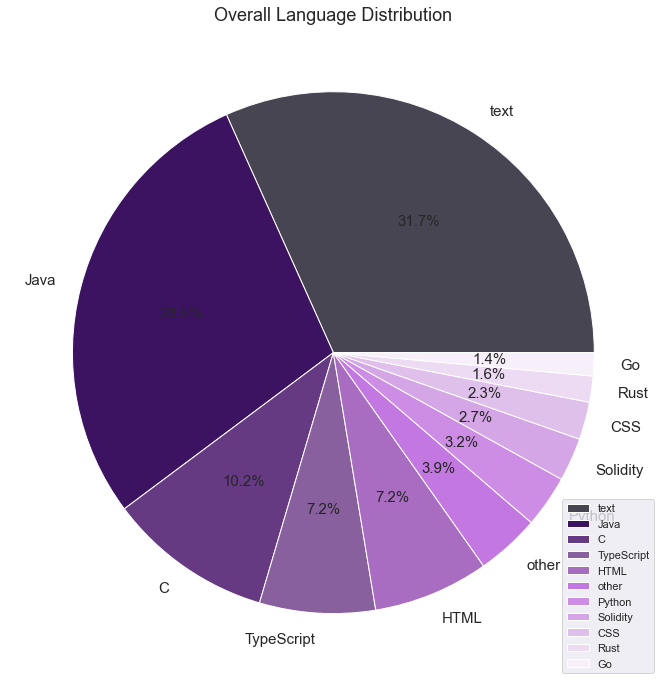

In [104]:
plt.figure(figsize=(16,12))
mylabels = ['text', 'Java', 'C', 'TypeScript', 'HTML', 'other', 'Python', 'Solidity',
       'CSS', 'Rust', 'Go']
mycolors = ['#484553', '#3c1361', '#663a82', '#89609e', '#a86cc1', '#c377e0', '#cd8de5', '#d5a6e6', '#dfc0eb', '#eddbf4', '#f7f0fa']
textprops = {"fontsize":15}
plt.pie(labels.percent, labels = mylabels, colors = mycolors, textprops=textprops, autopct='%.1f%%')
plt.legend()
plt.title('Overall Language Distribution',fontsize=18)
plt.show() 


### Takeaway: text, Java and C/C++ are the most common languages for metaverse repos.

***

## Question 1: What are the most common words in READMEs?

In [105]:
train.head()

,repo,language,readme_contents
624,Spectruth/Metaverse,text,text
0,M3-org/awesome-metaverse,text,awesome awesome awesome badge svg awesome list...
643,flynnhandley/metaverse,other,h1 align center img src 124135 361502 raikfcqu...
181,GoMeta/leaderboard,other,leaderboard sample project repository contains...
750,qxl0/metaverse,Java,next tailwind cs show tailwind cs tailwindcss ...


In [106]:
# Pull all text from readme_contents together
all_content = ' '.join(train.readme_contents)

In [107]:
# Look at all content
all_content[:100]

'text awesome awesome awesome badge svg awesome list awesome project information resource wikipedia w'

**Note**: 'text' needs to be exluded.

In [109]:
# The most frequent words from all content
pd.Series(all_content.split()).value_counts().head(20)

href       2171
detail     1997
summary    1942
git        1181
0          1142
open       1059
13          975
img         922
project     918
2022        806
src         766
2           696
clone       679
app         678
npm         651
width       601
doc         584
bit         576
install     573
08          557
dtype: int64

In [110]:
# Store content frequency into dataframe
all_freq = pd.DataFrame(pd.Series((all_content.split())).value_counts().head(20), columns = ['frequency'])

In [111]:
all_freq

,Frequency
href,2171
detail,1997
summary,1942
git,1181
0,1142
open,1059
13,975
img,922
project,918
2022,806


<AxesSubplot:title={'center':'Top 20 Most Common Words in Metaverse READMEs'}, xlabel='Words', ylabel='Frequency'>

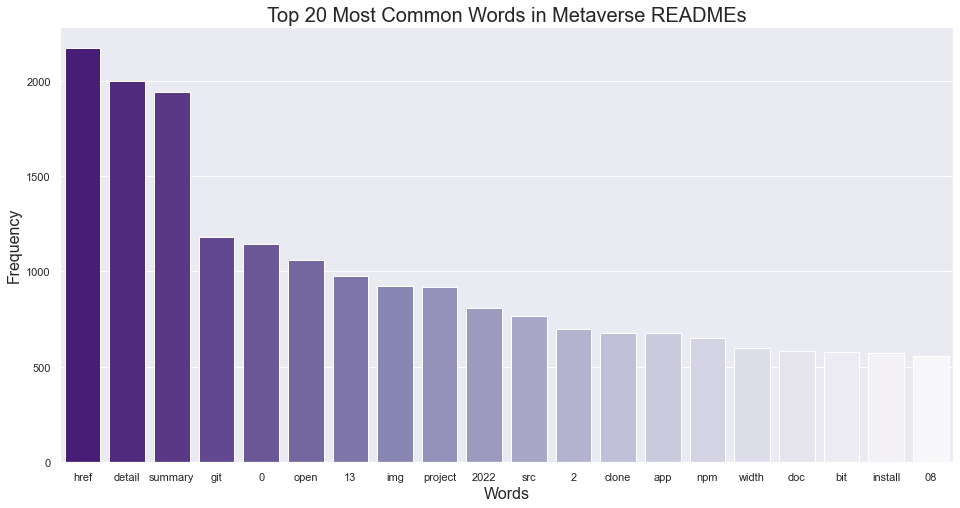

In [112]:
# Visualize most frequent words
plt.figure(figsize = (16,8))
plt.xlabel('Words', fontsize = 15)
plt.ylabel('Frequency', fontsize = 15)
plt.title('Top 20 Most Common Words in Metaverse READMEs', fontsize = 20)
sns.barplot(x=all_freq.index, y=all_freq.frequency, palette ='Purples_r')

### Takeaway: '0', 'app', 'doc', 'create', 'img', 'next', 'project', 'run', etc. are the most common words.

***

## Question 2: Does the length of the README vary by programming language?

In [140]:
train.language.value_counts()

text          177
Java          159
C              57
TypeScript     40
HTML           40
other          22
Python         18
Solidity       15
CSS            13
Rust            9
Go              8
Name: language, dtype: int64

In [141]:
# Concatenate readme content together for each language
text = ' '.join(train[train.language == 'text'].readme_contents)
java = ' '.join(train[train.language == 'Java'].readme_contents)
c = ' '.join(train[train.language == 'C'].readme_contents)
typescript = ' '.join(train[train.language == 'TypeScript'].readme_contents)
html = ' '.join(train[train.language == 'HTML'].readme_contents)
other = ' '.join(train[train.language == 'other'].readme_contents)
python = ' '.join(train[train.language == 'Python'].readme_contents)
solidity = ' '.join(train[train.language == 'Solidity'].readme_contents)
css = ' '.join(train[train.language == 'CSS'].readme_contents)
rust = ' '.join(train[train.language == 'Rust'].readme_contents)
go = ' '.join(train[train.language == 'Go'].readme_contents)

In [142]:
# Putting all language content in a dataframe
language = pd.DataFrame((text,java,c,typescript,html,other,python,solidity, css,rust,go), index =['text', 'java', 'c', 'typescript', 'html', 'other', 'python','solidity', 'css', 'rust', 'go'], columns = ['content'])

In [143]:
language

,content
text,text awesome awesome awesome badge svg awesome...
java,next tailwind cs show tailwind cs tailwindcss ...
c,project apollo goal create opensource server p...
typescript,getting started create react app project wa bo...
html,text title metaversity foundation open social...
other,h1 align center img src 124135 361502 raikfcqu...
python,text blender toolkit blender add mvt addon plu...
solidity,metaverser' smart contract metaverser first bl...
css,h1 align center landing page h1 align center i...
rust,align center img src zero img favicon png widt...


In [144]:
# Create length column that represents the total length of the content
language['length'] = language.content.str.len()

In [145]:
# Create count column -> the number of repo of each language
language['count'] = [177, 159, 57, 40, 40, 22, 18, 15, 13, 9, 8]

In [163]:
# Create avg length column represents the avg lenth of readme countent per language
language['avg_length'] = language['length']/language['count']
# Sort dataframe by avg length to show the longest readmes
language = language.sort_values(by ='avg_length', ascending = False)

<AxesSubplot:title={'center':'Average README Length by Programming Language'}, xlabel='Programming Language', ylabel='avg_length'>

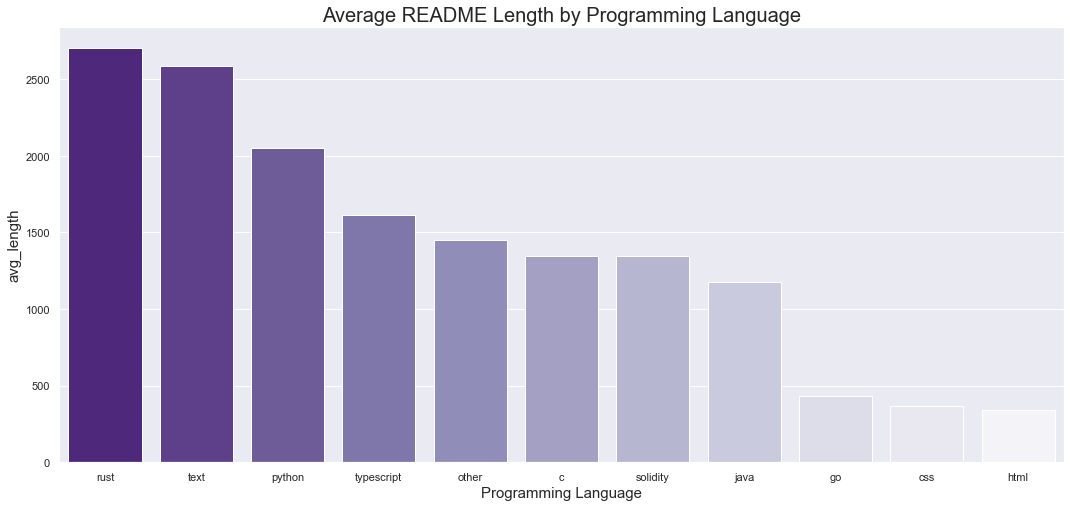

In [166]:
# Visualize most frequent words
plt.figure(figsize = (18,8))
plt.xlabel('Programming Language', fontsize = 15)
plt.ylabel('Avg README Length', fontsize = 15)
plt.title('Average README Length by Programming Language', fontsize = 20)
sns.barplot(x=language.index, y=language['avg_length'], palette ='Purples_r')

### Takeaway:
#### ◾ Yes, READMEs length vary by programming language.
#### ◾ READMEs that have the longest length on average are Rust, text, Python, typescript, and other.
#### ◾ READMEs that have the shortest length on average are HTML, CSS, GO, Java, and Solidity.

***

## Question 3: Do different programming languages use a different number of unique words?
### NOTE: I will be trying different color palettes in this section. Will choose one from them for final presentation.

### Looking at most common words per language

**Languages**: text, java, c, typescript, html, other, python, solidity, css, rust, go

#### 🔸	text

In [180]:
text_freq = pd.DataFrame(pd.Series(text.split()).value_counts().head(20), columns = ['frequency'])
text_freq.head()

,frequency
detail,1936
summary,1930
href,1910
git,1046
13,964


<AxesSubplot:title={'center':"Top 20 Most Common Words for Programming Language 'text'"}, xlabel='Words', ylabel='frequency'>

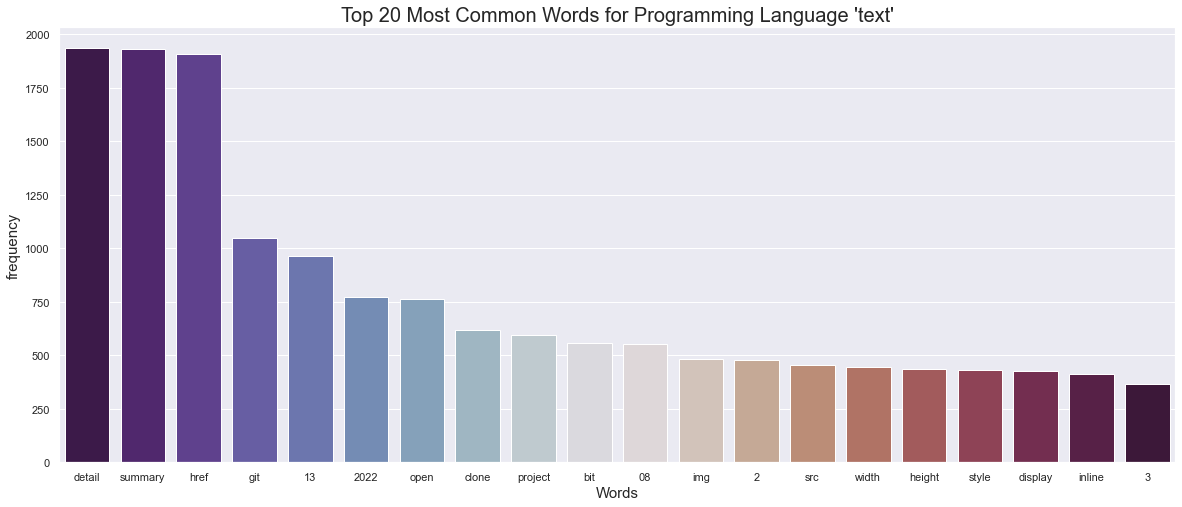

In [206]:
# Visualize most frequent words for text repos
plt.figure(figsize = (20,8))
plt.xlabel('Words', fontsize = 15)
plt.ylabel('Frequency', fontsize = 15)
plt.title("Top 20 Most Common Words for Programming Language 'text'", fontsize = 20)
sns.barplot(x=text_freq.index, y=text_freq.frequency, palette ='twilight_shifted')

#### 'detial', 'summary', 'href', 'git', '13' are the most common words for the READMEs that programming language is text.

#### 🔸	Java

<AxesSubplot:title={'center':"Top 20 Most Common Words for Programming Language 'Java'"}, xlabel='Words', ylabel='frequency'>

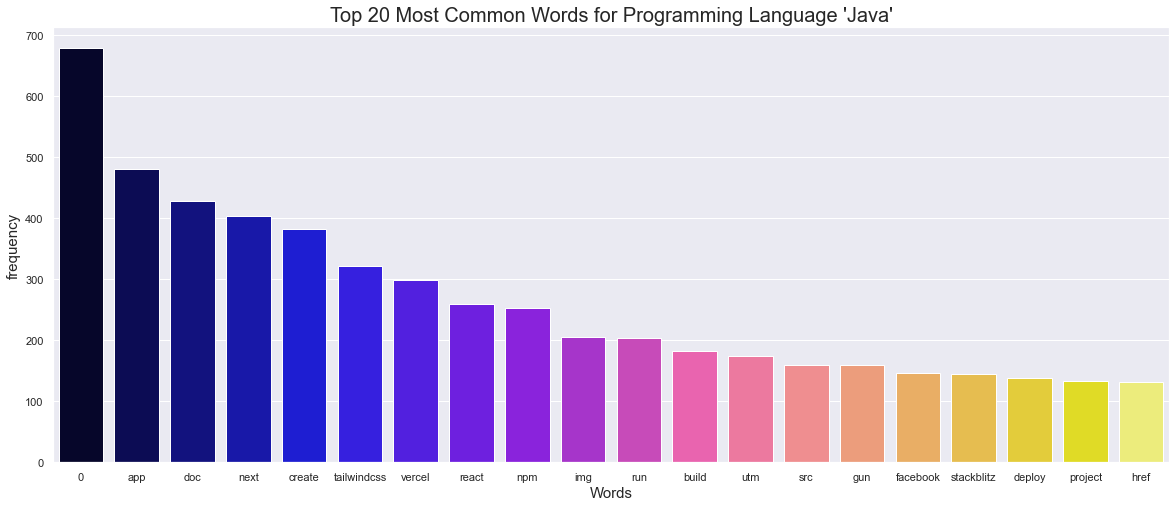

In [205]:
java_freq = pd.DataFrame(pd.Series(java.split()).value_counts().head(20), columns = ['frequency'])
# Visualize most frequent words for text repos
plt.figure(figsize = (20,8))
plt.xlabel('Words', fontsize = 15)
plt.ylabel('Frequency', fontsize = 15)
plt.title("Top 20 Most Common Words for Programming Language 'Java'", fontsize = 20)
sns.barplot(x=java_freq.index, y=java_freq.frequency, palette ='gnuplot2')

#### '0', 'app', 'doc', 'next', 'create' are the most common words for the READMEs that programming language is Java.

#### 🔸	C

<AxesSubplot:title={'center':"Top 20 Most Common Words for Programming Language 'C'"}, xlabel='Words', ylabel='frequency'>

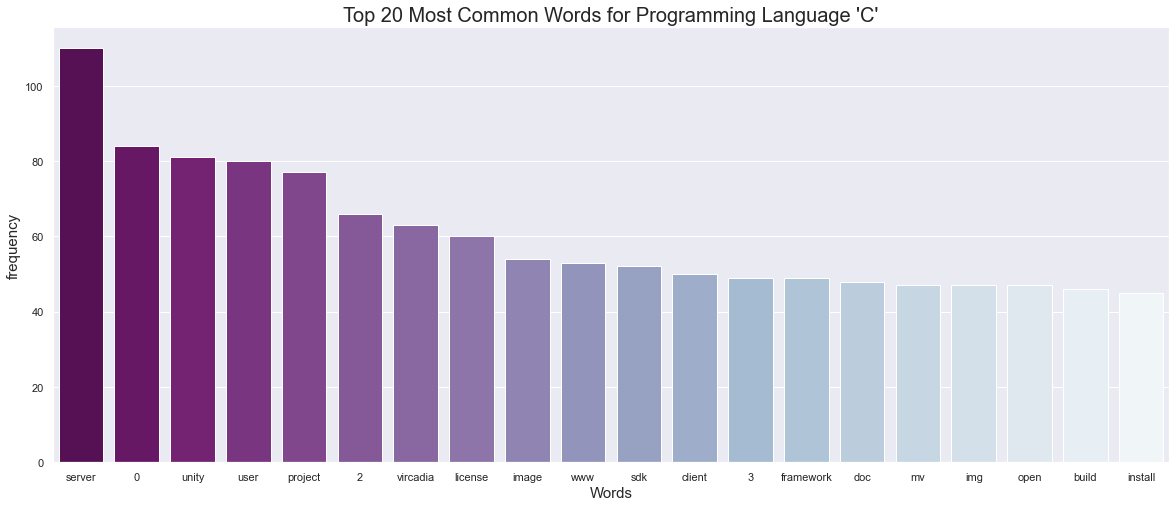

In [204]:
# Storing frequency into dataframe
c_freq = pd.DataFrame(pd.Series(c.split()).value_counts().head(20), columns = ['frequency'])
# Visualize most frequent words for text repos
plt.figure(figsize = (20,8))
plt.xlabel('Words', fontsize = 15)
plt.ylabel('Frequency', fontsize = 15)
plt.title("Top 20 Most Common Words for Programming Language 'C'", fontsize = 20)
sns.barplot(x=c_freq.index, y=c_freq.frequency, palette ='BuPu_r')

#### 'server', '0', 'unity', 'user', 'project' are the most common words for the READMEs that programming language is text.

#### 🔸	TypeScript

<AxesSubplot:title={'center':"Top 20 Most Common Words for Programming Language 'TypeScript'"}, xlabel='Words', ylabel='frequency'>

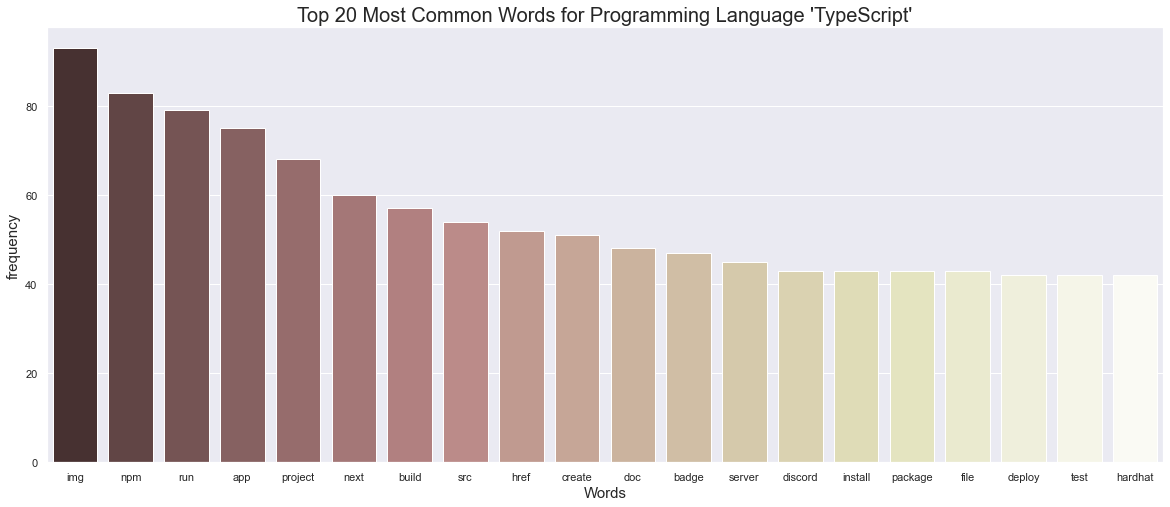

In [203]:
# Storing frequency into dataframe
type_freq = pd.DataFrame(pd.Series(typescript.split()).value_counts().head(20), columns = ['frequency'])
# Visualize most frequent words for text repos
plt.figure(figsize = (20,8))
plt.xlabel('Words', fontsize = 15)
plt.ylabel('Frequency', fontsize = 15)
plt.title("Top 20 Most Common Words for Programming Language 'TypeScript'", fontsize = 20)
sns.barplot(x=type_freq.index, y=type_freq.frequency, palette ='pink')

#### 'img', 'npm', 'run', 'app', 'project' are the most common words for the READMEs that programming language is text.

#### 🔸	HTML

<AxesSubplot:title={'center':"Top 20 Most Common Words for Programming Language 'HTML'"}, xlabel='Words', ylabel='frequency'>

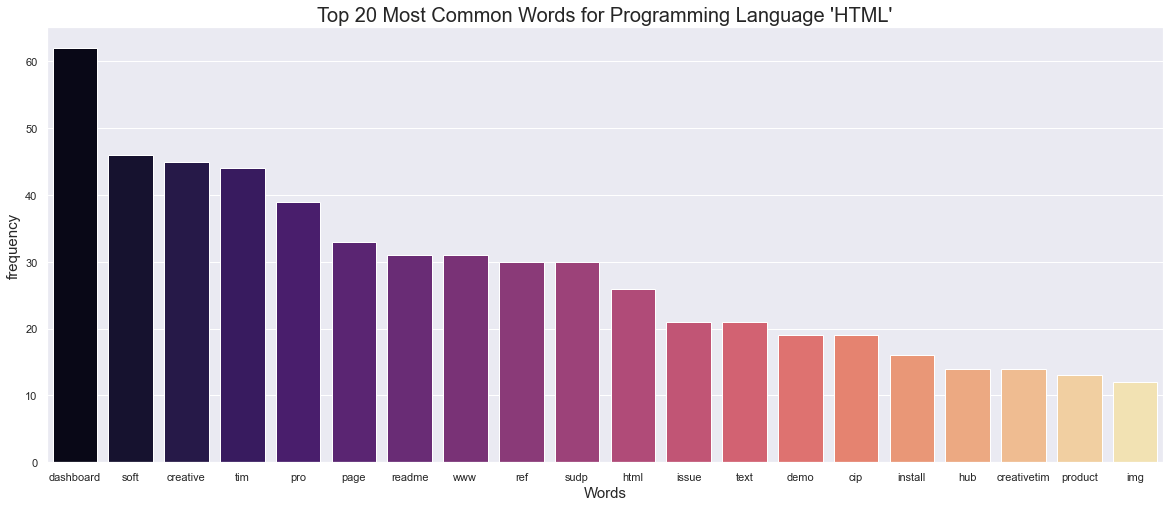

In [202]:
# Storing frequency into dataframe
html_freq = pd.DataFrame(pd.Series(html.split()).value_counts().head(20), columns = ['frequency'])
# Visualize most frequent words for text repos
plt.figure(figsize = (20,8))
plt.xlabel('Words', fontsize = 15)
plt.ylabel('Frequency', fontsize = 15)
plt.title("Top 20 Most Common Words for Programming Language 'HTML'", fontsize = 20)
sns.barplot(x=html_freq.index, y=html_freq.frequency, palette ='magma')

#### 'dashboard', 'soft', 'creative', 'tim', 'pro'  are the most common words for the READMEs that programming language is text.

#### 🔸 other

<AxesSubplot:title={'center':"Top 20 Most Common Words for Programming Language 'other'"}, xlabel='Words', ylabel='frequency'>

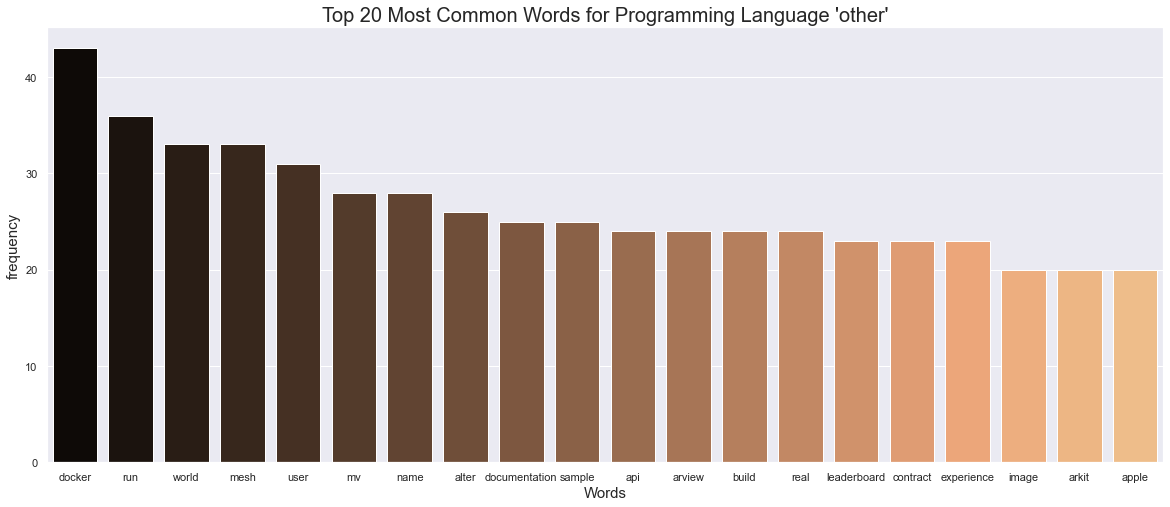

In [201]:
# Storing frequency into dataframe
other_freq = pd.DataFrame(pd.Series(other.split()).value_counts().head(20), columns = ['frequency'])
# Visualize most frequent words for text repos
plt.figure(figsize = (20,8))
plt.xlabel('Words', fontsize = 15)
plt.ylabel('Frequency', fontsize = 15)
plt.title("Top 20 Most Common Words for Programming Language 'other'", fontsize = 20)
sns.barplot(x=other_freq.index, y=other_freq.frequency, palette ='copper')

 are the most common words for the READMEs that programming language is text.

#### 🔸	Python

 are the most common words for the READMEs that programming language is text.

#### 🔸	Solidity

 are the most common words for the READMEs that programming language is text.

#### 🔸	CSS

 are the most common words for the READMEs that programming language is text.

#### 🔸	Rust

 are the most common words for the READMEs that programming language is text.

#### 🔸	GO

**Seaborn palette**
'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'crest', 'crest_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'flare', 'flare_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'icefire', 'icefire_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'mako', 'mako_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'rocket', 'rocket_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'vlag', 'vlag_r', 'winter', 'winter_r'

### Takeaway:

***

## Question 4: Are there any words that uniquely identify a programming language?

### Takeaway:

***